<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/pca_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install wpca

In [ ]:
# @title Import packages

#import cupy as cp
#from cupyx.scipy.special import erf
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil
import scipy as sp

#from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.decomposition import PCA
from wpca import EMPCA, WPCA

import h5py

In [ ]:
instance_id  = 23898
gpu_id = 0
k_power = 3

##instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
##gpu_id_list = [0,1,0,0,1,3]
##k_power = 3

#instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
#gpu_id_list = [2,0,2,1,3,3]
#k_power = 2

#instance_id_list = [16825, 30829, 54107, 98328, 112172]
#gpu_id_list = [3, 3, 3, 3, 0]
#k_power = 1

#instance_id_list = [4366, 42923, 66511, 94580]
#gpu_id_list = [1,1,3,1]
#k_power = 0

from google.colab import drive
drive.mount('/content/gdrive/')
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
folder_path_main = folder_path + f'/exprf_id_{instance_id}_{gpu_id}'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd())

exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')

Mounted at /content/gdrive/
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_3


# PCA Test

In [ ]:
l= 9
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 0# 19 = 6 sigmas

In [ ]:
max_pt = np.argmax( exprf )
max_coord = np.unravel_index(max_pt, exprf.shape)

x,y,z = max_coord[0], max_coord[1], max_coord[2]

x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

max_sub_vol = exprf[x_min:x_max, y_min:y_max, z_min:z_max]

total_mass, max_amp = np.sum(max_sub_vol), np.max(max_sub_vol)

coords = np.where( max_sub_vol > threshold)
amps, coords = max_sub_vol[coords], np.array(coords).T
amps = (amps-threshold)/(np.max(max_sub_vol)-threshold)


#coord_amp_dict = [(tuple(coord), amp) for coord, amp in zip(coords, amps)]
coord_amp = np.array( [(coord[0],coord[1],coord[2], amp   ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.
coords.shape

(1331, 3)

In [ ]:
pca = PCA(n_components=3)
pca.fit(coords)
print("Number of points = " , coords.shape[0])
print("Principal components:\n", pca.components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Number of points =  1331
Principal components:
 [[ 0.          0.70710678  0.70710678]
 [-1.         -0.         -0.        ]
 [-0.          0.70710678 -0.70710678]]
Explained variance ratio: [0.33333333 0.33333333 0.33333333]


Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_3/exprf_id_23898_0


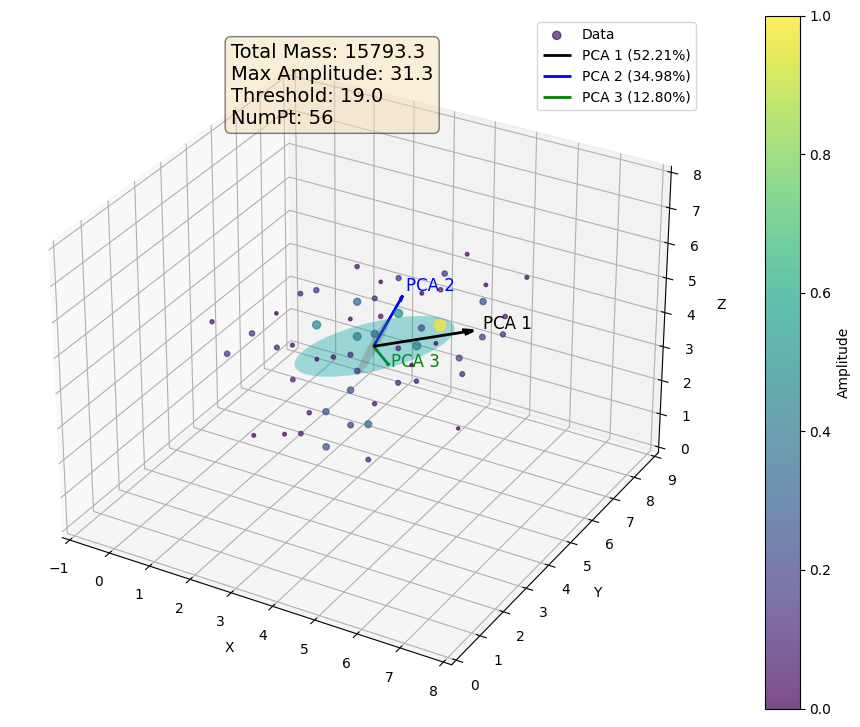

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

# Plot original data points
#ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=2, c='r', label='Original Data')
sc = ax.scatter(coord_amp[:, 0], coord_amp[:, 1], coord_amp[:, 2], s= (5+60*coord_amp[:, 3]) , c=coord_amp[:, 3], alpha = 0.7,  cmap='viridis', label='Data')

origin = pca.mean_
pca1 = 5*pca.components_[0] * (pca.explained_variance_ratio_[0]) # Scale by 5 for visualization
pca2 = 5*pca.components_[1] * (pca.explained_variance_ratio_[1])
pca3 = 5*pca.components_[2] * (pca.explained_variance_ratio_[2])

ax.quiver(*origin, *pca1, color='k', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
ax.quiver(*origin, *pca2, color='b', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
ax.quiver(*origin, *pca3, color='g', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')
ax.text(*origin + pca1*1.1, 'PCA 1', color='k', fontsize=12)
ax.text(*origin + pca2*1.1, 'PCA 2', color='b', fontsize=12)
ax.text(*origin + pca3*1.1, 'PCA 3', color='g', fontsize=12)

a0 = 0.25
ellipse_radius1 = a0*(pca.explained_variance_[0])  # Larger radius PC1
ellipse_radius2 = a0*(pca.explained_variance_[1])  # Smaller radius PC2
ellipse_radius3 = a0*(pca.explained_variance_[2])  # Smallest radius PC3

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = origin[0] + (ellipse_radius1 * pca1[0] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[0] * np.outer(np.sin(u), np.sin(v)))
y = origin[1] + (ellipse_radius1 * pca1[1] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[1] * np.outer(np.sin(u), np.sin(v)))
z = origin[2] + (ellipse_radius1 * pca1[2] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[2] * np.outer(np.sin(u), np.sin(v)))
ax.plot_surface(x, y, z, color='cyan', alpha=0.2)


x = origin[0] + (ellipse_radius2 * pca2[0] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[0] * np.outer(np.sin(u), np.sin(v)))
y = origin[1] + (ellipse_radius2 * pca2[1] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[1] * np.outer(np.sin(u), np.sin(v)))
z = origin[2] + (ellipse_radius2 * pca2[2] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[2] * np.outer(np.sin(u), np.sin(v)))
ax.plot_surface(x, y, z, color='red', alpha=0.1)

# Rotate by angle
#ax.view_init(elev=20, azim=40)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Amplitude')
sc.set_clim([0, 1])

textstr = f'Total Mass: {total_mass:.1f}\nMax Amplitude: {max_amp:.1f}\nThreshold: {threshold:.1f}\nNumPt: {coords.shape[0]}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.figtext(0.45, 0.85, textstr, fontsize=14, verticalalignment='top', bbox=props)

ax.set_xlim([coords[:, 0].min()-1, coords[:, 0].max()+1])
ax.set_ylim([coords[:, 1].min()-1, coords[:, 1].max()+1])
ax.set_zlim([coords[:, 2].min()-1, coords[:, 2].max()+1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
folder_path_main = folder_path + f'/exprf_id_{instance_id}_{gpu_id}'
os.chdir(folder_path_main)
print("Current Working Directory:", os.getcwd())

plt.savefig('PCA_3D_View.pdf', bbox_inches='tight', pad_inches=0)  # Saves the current figure
plt.show()

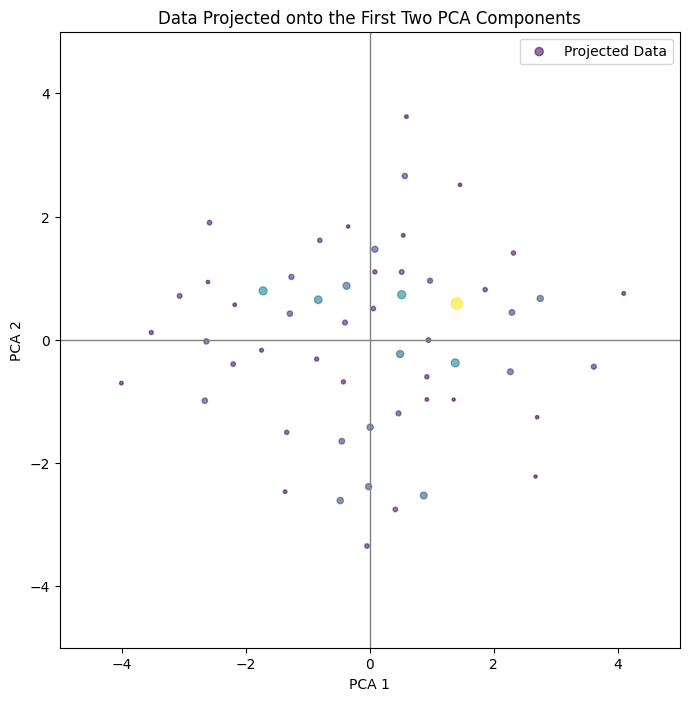

In [ ]:
transformed_data = pca.transform(coords)  # Project the data onto the first two principal components

# Create a 2D plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot transformed data
ax.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.6, c=coord_amp[:, 3], s= (5+60*coord_amp[:, 3]) ,  cmap='viridis', label='Projected Data')


# Optionally, add annotations for origin and component vectors if needed
ax.axhline(0, color='gray', lw=1)
ax.axvline(0, color='gray', lw=1)

# Labeling axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.set_title('Data Projected onto the First Two PCA Components')
ax.legend()

plt.show()


In [ ]:
num_pts =  coords.shape[0]
pca_ev1 = pca.explained_variance_ratio_[0]
pca_ev3 = pca.explained_variance_ratio_[2]

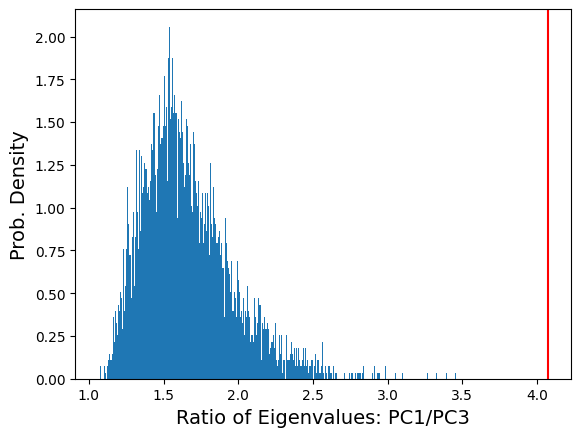

In [ ]:
pca_list_ratio = []

for _ in range(10000):

    rand_dist = np.random.uniform(-1,1,(num_pts,3))
    pca = PCA(n_components=3)
    pca.fit(rand_dist )

    #print("Principal components:\n", pca.components_)
    #print("Explained variance ratio:", pca.explained_variance_ratio_)

    pca_list_ratio.append( pca.explained_variance_ratio_[0]/  pca.explained_variance_ratio_[2])

plt.hist(pca_list_ratio, bins=1000, density =True);
plt.xlabel(f'Ratio of Eigenvalues: PC1/PC3', fontsize =14)
plt.ylabel(f'Prob. Density', fontsize =14)
ax.grid(True)
plt.axvline(pca_ev1/pca_ev3, c='red')

# PCA Test with loops

In [ ]:
# @title Import packages

#import cupy as cp
#from cupyx.scipy.special import erf
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.backends.backend_pdf import PdfPages

import numpy as np
#import pyfftw
import matplotlib.pyplot as plt
import imageio
import gc
import os
import psutil
import scipy as sp

#from scipy.special import erf
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.decomposition import PCA


import h5py

In [ ]:
# @title PCA_Analysis with loops
l= 5
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 2 # 19 = 6 sigmas, 14 = 5 sigmas


#instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
#gpu_id_list = [0,1,0,0,1,3]
#k_power = 3

#instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
#gpu_id_list = [2,0,2,1,3,3]
#k_power = 2

#instance_id_list = [16825, 30829, 54107, 98328, 112172]
#gpu_id_list = [3, 3, 3, 3, 0]
#k_power = 1

instance_id_list = [4366, 42923, 66511, 94580]
gpu_id_list = [1,1,3,1]
k_power = 0



figs_list = []
hists_list = []


for instance_id, gpu_id in zip(instance_id_list, gpu_id_list):
    # Initialize an instance of RFSIM
    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
    os.chdir(folder_path)
    exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')

    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
    folder_path_main = folder_path + f'/exprf_id_{instance_id}_{gpu_id}'

    # Anylsis
    max_pt = np.argmax( exprf )
    max_coord = np.unravel_index(max_pt, exprf.shape)

    x,y,z = max_coord[0], max_coord[1], max_coord[2]

    x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
    y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
    z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

    max_sub_vol = exprf[x_min:x_max, y_min:y_max, z_min:z_max]

    total_mass, max_amp = np.sum(max_sub_vol), np.max(max_sub_vol)

    coords = np.where( max_sub_vol > threshold)
    amps, coords = max_sub_vol[coords], np.array(coords).T
    amps = (amps-threshold)/(np.max(max_sub_vol)-threshold)


    #coord_amp_dict = [(tuple(coord), amp) for coord, amp in zip(coords, amps)]
    coord_amp = np.array( [(coord[0],coord[1],coord[2], amp   ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.
    num_pts =  coords.shape[0]

    pca = PCA(n_components=3)
    pca.fit(coords)

    # Graph plotting
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')

    # Plot original data points
    #ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], s=2, c='r', label='Original Data')
    sc = ax.scatter(coord_amp[:, 0], coord_amp[:, 1], coord_amp[:, 2], s= (5+60*coord_amp[:, 3]) , c=coord_amp[:, 3], alpha = 0.7,  cmap='viridis', label='Data')

    origin = pca.mean_
    pca1 = 5*pca.components_[0] * (pca.explained_variance_ratio_[0]) # Scale by 5 for visualization
    pca2 = 5*pca.components_[1] * (pca.explained_variance_ratio_[1])
    pca3 = 5*pca.components_[2] * (pca.explained_variance_ratio_[2])

    ax.quiver(*origin, *pca1, color='k', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax.quiver(*origin, *pca2, color='b', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    ax.quiver(*origin, *pca3, color='g', linewidth=2, arrow_length_ratio=0.1, label=f'PCA 3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')
    ax.text(*origin + pca1*1.1, 'PCA 1', color='k', fontsize=12)
    ax.text(*origin + pca2*1.1, 'PCA 2', color='b', fontsize=12)
    ax.text(*origin + pca3*1.1, 'PCA 3', color='g', fontsize=12)

    a0 = 0.25
    ellipse_radius1 = a0*(pca.explained_variance_[0])  # Larger radius PC1
    ellipse_radius2 = a0*(pca.explained_variance_[1])  # Smaller radius PC2
    ellipse_radius3 = a0*(pca.explained_variance_[2])  # Smallest radius PC3

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = origin[0] + (ellipse_radius1 * pca1[0] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[0] * np.outer(np.sin(u), np.sin(v)))
    y = origin[1] + (ellipse_radius1 * pca1[1] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[1] * np.outer(np.sin(u), np.sin(v)))
    z = origin[2] + (ellipse_radius1 * pca1[2] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius2 * pca2[2] * np.outer(np.sin(u), np.sin(v)))
    ax.plot_surface(x, y, z, color='cyan', alpha=0.2)


    x = origin[0] + (ellipse_radius2 * pca2[0] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[0] * np.outer(np.sin(u), np.sin(v)))
    y = origin[1] + (ellipse_radius2 * pca2[1] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[1] * np.outer(np.sin(u), np.sin(v)))
    z = origin[2] + (ellipse_radius2 * pca2[2] * np.outer(np.cos(u), np.sin(v)) + ellipse_radius3 * pca3[2] * np.outer(np.sin(u), np.sin(v)))
    ax.plot_surface(x, y, z, color='red', alpha=0.1)

    # Rotate by angle
    #ax.view_init(elev=20, azim=40)

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Amplitude')
    sc.set_clim([0, 1])

    textstr = f'ID:{instance_id}_{gpu_id}\nTotal Mass: {total_mass:.1f}\nMax Amplitude: {max_amp:.1f}\nThreshold: {threshold:.1f}\nNumPt: {num_pts}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.figtext(0.4, 0.85, textstr, fontsize=14, verticalalignment='top', bbox=props)

    ax.set_xlim([coords[:, 0].min()-1, coords[:, 0].max()+1])
    ax.set_ylim([coords[:, 1].min()-1, coords[:, 1].max()+1])
    ax.set_zlim([coords[:, 2].min()-1, coords[:, 2].max()+1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
    os.chdir(folder_path)
    print("Current Working Directory:", os.getcwd() )

    figs_list.append(fig)


    #plt.savefig('PCA_3D_View.pdf', bbox_inches='tight', pad_inches=0)  # Saves the current figure
    #figs_list.append(fig)
    #plt.show()

    pca_list_ratio = []
    num_pts =  coords.shape[0]
    pca_ev1 = pca.explained_variance_ratio_[0]
    pca_ev3 = pca.explained_variance_ratio_[2]


    hist_fig = plt.figure(figsize=(12,9))
    for _ in range(10000):

        rand_dist = np.random.uniform(-1,1,(num_pts,3))
        pca = PCA(n_components=3)
        pca.fit(rand_dist )
        pca_list_ratio.append( pca.explained_variance_ratio_[0]/ pca.explained_variance_ratio_[2])

    plt.hist(pca_list_ratio, bins=1000, density =True)
    plt.axvline(pca_ev1/pca_ev3, c='red')

    textstr = f'ID:{instance_id}_{gpu_id}\nTotal Mass: {total_mass:.1f}\nMax Amplitude: {max_amp:.1f}\nThreshold: {threshold:.1f}\nNumPt: {num_pts}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.figtext(0.4, 0.85, textstr, fontsize=14, verticalalignment='top', bbox=props)

    plt.xlabel('Ratio of explained varience: PCA1/PCA3', fontsize = 14)
    plt.ylabel('Prob. density.', fontsize = 14)
    hists_list.append(hist_fig)

    plt.close('all')


Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_0
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_0
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_0
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_0


In [ ]:
with PdfPages(folder_path + f'/PCA_Scatter_Plots_l={l}.pdf') as pdf:
    for fig in figs_list:
        pdf.savefig(fig)

with PdfPages(folder_path + f'/Sphericity_by_PCA_l={l}.pdf') as pdf:
    for hist_fig in hists_list:
        pdf.savefig(hist_fig)

# EMPCA Test

In [ ]:
max_pt = np.argmax( exprf )
max_coord = np.unravel_index(max_pt, exprf.shape)

x,y,z = max_coord[0], max_coord[1], max_coord[2]

x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

max_sub_vol = exprf[x_min:x_max, y_min:y_max, z_min:z_max]

total_mass, max_amp = np.sum(max_sub_vol), np.max(max_sub_vol)

coords = np.where( max_sub_vol > threshold)
total_th_mass = np.sum(max_sub_vol[coords])
amps, coords = max_sub_vol[coords], np.array(coords).T
amps = amps/total_th_mass


#coord_amp_dict = [(tuple(coord), amp) for coord, amp in zip(coords, amps)]
coord_amp = np.array( [(coord[0],coord[1],coord[2], amp   ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.
coords.shape

(56, 3)

In [ ]:
weights = np.zeros_like(coords, dtype=np.float64)

for nn in range(coord_amp.shape[0]):
    weights[nn] = np.array( [coord_amp[nn][3],coord_amp[nn][3],coord_amp[nn][3]])

In [ ]:
empca = EMPCA(n_components=3)

In [ ]:
empca.fit(coords, weights)

EMPCA(n_components=3)

In [ ]:
print("Number of points = " , coords.shape[0])
print("Principal components:\n", empca.components_)
print("Explained variance ratio:", empca.explained_variance_ratio_)

Number of points =  56
Principal components:
 [[-0.88908392 -0.02553021 -0.45703172]
 [ 0.1437977  -0.96347519 -0.22591541]
 [-0.43457105 -0.26657787  0.86028149]]
Explained variance ratio: [0.52211918 0.34984772 0.12803309]


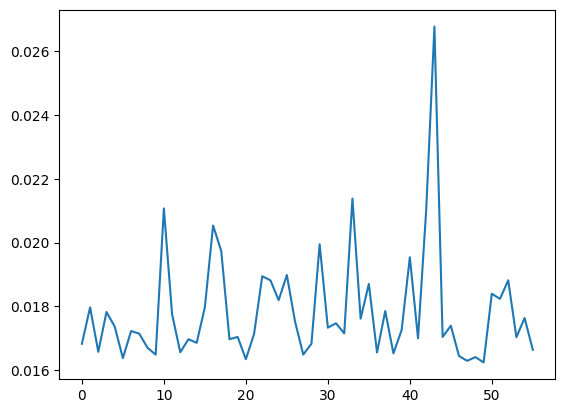

In [ ]:
plt.plot(amps)

In [ ]:
# @title Without threshold using WPCA

threshold = 0

max_pt = np.argmax( exprf )
max_coord = np.unravel_index(max_pt, exprf.shape)

x,y,z = max_coord[0], max_coord[1], max_coord[2]

x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

max_sub_vol = exprf[x_min:x_max, y_min:y_max, z_min:z_max]

total_mass, max_amp = np.sum(max_sub_vol), np.max(max_sub_vol)

coords = np.where( max_sub_vol > threshold)
total_th_mass = np.sum(max_sub_vol[coords])
amps, coords = max_sub_vol[coords], np.array(coords).T
#amps = amps/total_th_mass
amps = amps/np.sum(amps)


#coord_amp_dict = [(tuple(coord), amp) for coord, amp in zip(coords, amps)]
coord_amp = np.array( [(coord[0],coord[1],coord[2], amp   ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.
coords.shape

NameError: name 'exprf' is not defined

In [ ]:
weights = np.zeros_like(coords, dtype=np.float64)

for nn in range(coord_amp.shape[0]):
    weights[nn] = np.array( [coord_amp[nn][3],coord_amp[nn][3],coord_amp[nn][3]])

In [ ]:
empca = EMPCA(n_components=3 , max_iter = 200)
empca.fit(X = coords, weights=weights)
empca_vec = empca.components_
empca_ev = empca.explained_variance_ratio_
#empca.fit(X = coords, weights=np.ones_like(coords))

wpca = WPCA(n_components=3)
wpca.fit(X = coords, weights=weights)
wpca_vec = wpca.components_
wpca_ev = wpca.explained_variance_ratio_
#wpca.fit(X = coords, weights=np.ones_like(coords))

pca = PCA(n_components=3)
pca.fit(coords)
pca_vec = pca.components_
pca_ev = pca.explained_variance_ratio_

In [ ]:
print("Number of points = " , coords.shape[0])
print("Principal components:\n", empca_vec)
print("Explained variance ratio:", empca_ev)

Number of points =  1331
Principal components:
 [[-0.82375677  0.14114608 -0.5490925 ]
 [ 0.0999837  -0.91716641 -0.38575775]
 [-0.55805739 -0.37267086  0.74140973]]
Explained variance ratio: [0.38897905 0.38762196 0.38755003]


In [ ]:
print("Number of points = " , coords.shape[0])
print("Principal components:\n", wpca_vec)
print("Explained variance ratio:", wpca_ev)

Number of points =  1331
Principal components:
 [[ 0.8236029  -0.13974327  0.5496818 ]
 [-0.10124337  0.91738119  0.38491756]
 [-0.55805739 -0.37267086  0.74140973]]
Explained variance ratio: [0.37332237 0.36084342 0.26583421]


In [ ]:
print("Number of points = " , coords.shape[0])
print("Principal components:\n", pca_vec)
print("Explained variance ratio:", pca_ev)

Number of points =  1331
Principal components:
 [[ 0.          0.70710678  0.70710678]
 [-1.         -0.         -0.        ]
 [-0.          0.70710678 -0.70710678]]
Explained variance ratio: [0.33333333 0.33333333 0.33333333]


## WPCA Background sampling

In [ ]:
# @title Background Sampling for WPCA Test

from scipy.special import erf

def gaussian_to_exp(grf,lamb):
    grf_mean = np.mean(grf)
    grf_std_dev = np.std(grf)
    xu = 0.5 * (1 + erf((grf - grf_mean) / (np.sqrt(2) * grf_std_dev)))

    gc.collect()

    exprf = -1/lamb  * np.log(1 - xu)


    return exprf

pca_list_ratio = []
wpca_list_ratio = []
empca_list_ratio = []
l=32

threshold = 0

ss= 2*l +1

for _ in range(10000):

    white_noise = gaussian_to_exp(np.random.normal(size=[ss,ss,ss] ), 1)

    coords = np.where( white_noise > threshold)
    amps, coords = white_noise[coords], np.array(coords).T
    amps = amps/np.sum(amps)

    coord_amp = np.array( [(coord[0],coord[1],coord[2], amp ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.

    weights = np.zeros_like(coords, dtype=np.float64)

    for nn in range(coord_amp.shape[0]):
        weights[nn] = np.array( [coord_amp[nn][3],coord_amp[nn][3],coord_amp[nn][3]])

    #empca = EMPCA(n_components=3 , max_iter = 100)
    #empca.fit(X = coords, weights=weights)
    #empca.fit(X = coords, weights=np.ones_like(coords))
    #empca_list_ratio.append( empca.explained_variance_ratio_[0]/  empca.explained_variance_ratio_[2])

    wpca = WPCA(n_components=3)
    wpca.fit(X = coords, weights=weights)
    #wpca.fit(X = coords, weights=np.ones_like(coords))

    pca = PCA(n_components=3)
    pca.fit(coords)
    #print("Principal components:\n", pca.components_)
    #print("Explained variance ratio:", pca.explained_variance_ratio_)

    pca_list_ratio.append( pca.explained_variance_ratio_[0]/  pca.explained_variance_ratio_[2])
    wpca_list_ratio.append( wpca.explained_variance_ratio_[0]/  wpca.explained_variance_ratio_[2])

In [ ]:
wpca = WPCA(n_components=3)
wpca.fit(X = coords, weights=weights)
wpca_list_ratio.append( wpca.explained_variance_ratio_[0]/  wpca.explained_variance_ratio_[2])

In [ ]:
plt.hist(pca_list_ratio, bins=1000, density =True);
plt.title(f'James Sphericity Hypothesis (PCA)')
plt.xlabel(f'Ratio of Eigenvalues: PC1/PC3', fontsize =14)
plt.ylabel(f'Prob. Density', fontsize =14)
#plt.axvline(pca_ev[0]/pca_ev[2], c='red')
plt.show()

plt.hist(wpca_list_ratio, bins=1000, density =True);
plt.title(f'James Sphericity Hypothesis (WPCA)')
plt.xlabel(f'Ratio of Eigenvalues: WPC1/WPC3', fontsize =14)
plt.ylabel(f'Prob. Density', fontsize =14)
#plt.axvline(wpca_ev[0]/wpca_ev[2], c='red')
plt.show()


In [ ]:
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd() )
np.save(f'pca_whitenoise_ratio_l_{l}.npy', pca_list_ratio)
np.save(f'wpca_whitenoise_ratio_l_{l}.npy', wpca_list_ratio)

In [ ]:

plt.hist(empca_list_ratio, bins=1000, density =True);
plt.title(f'James Sphericity Hypothesis (EMPCA)')
plt.xlabel(f'Ratio of Eigenvalues: PC1/PC3', fontsize =14)
plt.ylabel(f'Prob. Density', fontsize =14)
ax.grid(True)
plt.axvline(empca_ev[0]/empca_ev[2], c='red')
plt.show()

 # WPCA in Loops

Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results
Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_1


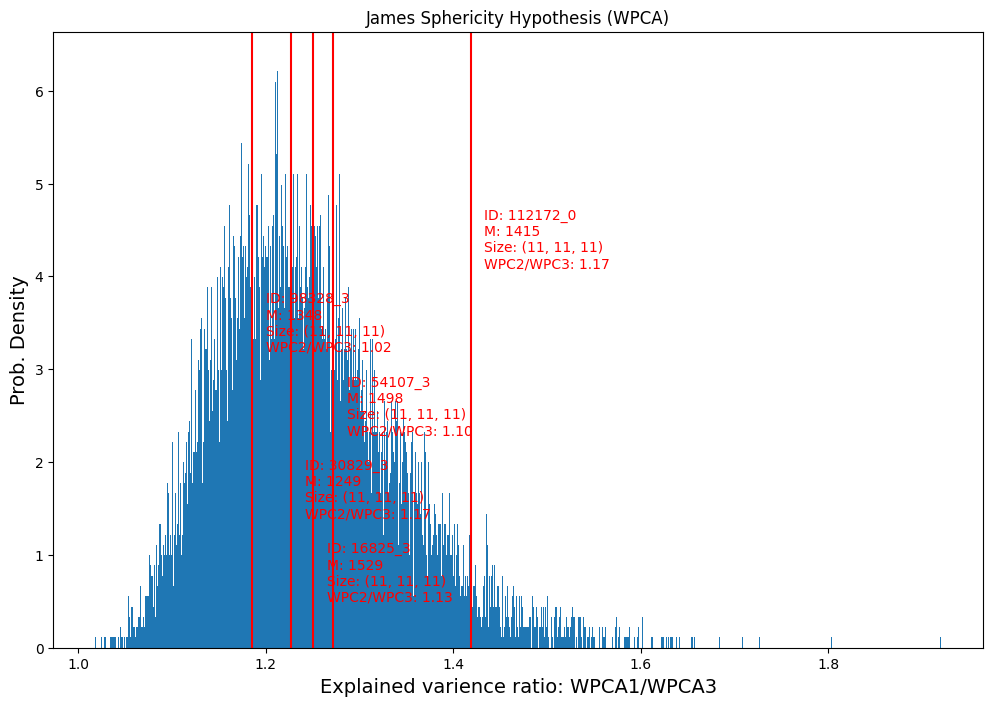

In [ ]:
l= 5
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 0 # 19 = 6 sigmas, 14 = 5 sigmas


#instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
#gpu_id_list = [0,1,0,0,1,3]
#k_power = 3

#instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
#gpu_id_list = [2,0,2,1,3,3]
#k_power = 2

instance_id_list = [16825, 30829, 54107, 98328, 112172]
gpu_id_list = [3, 3, 3, 3, 0]
k_power = 1

#instance_id_list = [4366, 42923, 66511, 94580]
#gpu_id_list = [1,1,3,1]
#k_power = 0

wpca_ev_list = []
wpca_vec_list = []

plt.figure(figsize=(12,8))

ii=0
for instance_id, gpu_id in zip(instance_id_list, gpu_id_list):
    # Initialize an instance of RFSIM
    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
    os.chdir(folder_path)
    exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')


    max_pt = np.argmax( exprf )
    max_coord = np.unravel_index(max_pt, exprf.shape)

    x,y,z = max_coord[0], max_coord[1], max_coord[2]

    x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
    y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
    z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

    max_sub_vol = exprf[x_min:x_max, y_min:y_max, z_min:z_max]

    #total_mass, max_amp = np.sum(max_sub_vol), np.max(max_sub_vol)

    coords = np.where( max_sub_vol > threshold)
    total_mass = np.sum(max_sub_vol)
    amps, coords = max_sub_vol[coords], np.array(coords).T
    amps = amps/total_mass


    #coord_amp_dict = [(tuple(coord), amp) for coord, amp in zip(coords, amps)]
    coord_amp = np.array( [(coord[0],coord[1],coord[2], amp   ) for coord, amp in zip(coords, amps)]) #Normalized amplitudes. Threshold = 0, Max Pt. = 1.

    weights = np.zeros_like(coords, dtype=np.float64)
    for nn in range(coord_amp.shape[0]):
        weights[nn] = np.array( [coord_amp[nn][3],coord_amp[nn][3],coord_amp[nn][3]])

    wpca = WPCA(n_components=3)
    wpca.fit(X = coords, weights=weights)

    wpca_ev_list.append(wpca.explained_variance_ratio_)
    wpca_vec_list.append(wpca.components_)

    wpca_ev1 = wpca.explained_variance_ratio_[0]
    wpca_ev2 = wpca.explained_variance_ratio_[1]
    wpca_ev3 = wpca.explained_variance_ratio_[2]
    wpca_ratio = wpca_ev1 / wpca_ev3
    wpca_shape_ratio = wpca_ev2 / wpca_ev3

    plt.axvline(wpca_ratio, c='red')
    annotation_text = f"ID: {instance_id}_{gpu_id}\nM: {int(total_mass)}\nSize: {max_sub_vol.shape}\nWPC2/WPC3: {wpca_shape_ratio:.2f}"
    plt.annotate(annotation_text,
                 (wpca_ratio, 0.5),
                 textcoords="offset points",
                 xytext=(10,ii*60),
                 ha='left',
                 color='red')

    ii = ii + 1


folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd() )

white_noise_samples = np.load(f'wpca_whitenoise_ratio_l_{l}.npy')
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd() )


plt.hist(white_noise_samples, bins=1000, density =True);
plt.title(f'James Sphericity Hypothesis (WPCA)')
plt.xlabel(f'Explained varience ratio: WPCA1/WPCA3', fontsize =14)
plt.ylabel(f'Prob. Density', fontsize =14)

plt.savefig(f'WPCA_Sphericity_Test_k_{k_power}_l_{l}.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
np.save(f'wpca_ev_k_{k_power}_l_{l}.npy', wpca_ev_list)
np.save(f'wpca_vec_k_{k_power}_l_{l}.npy', wpca_vec_list)

In [ ]:
import numpy as np

folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results'
os.chdir(folder_path)
print("Current Working Directory:", os.getcwd() )
white_noise_samples = np.load(f'wpca_whitenoise_ratio_l_{l}.npy')


Current Working Directory: /content/gdrive/MyDrive/2023 RFSimulations/simulated_results


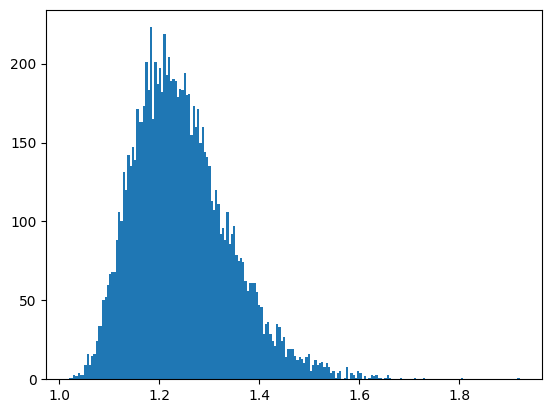

In [ ]:
plt.hist(white_noise_samples,bins=200);

# Visualization

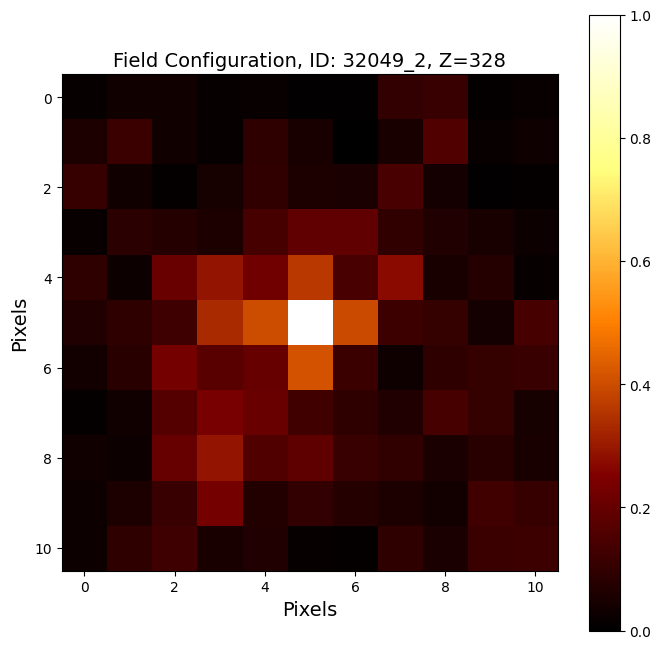

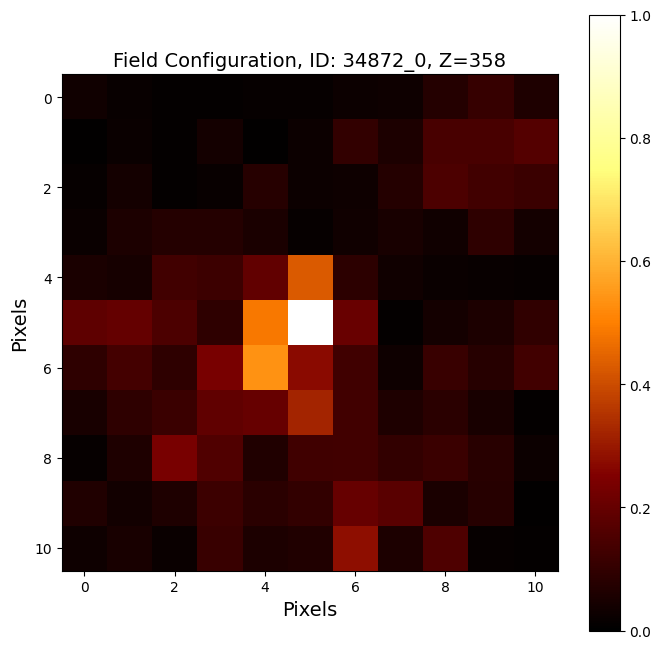

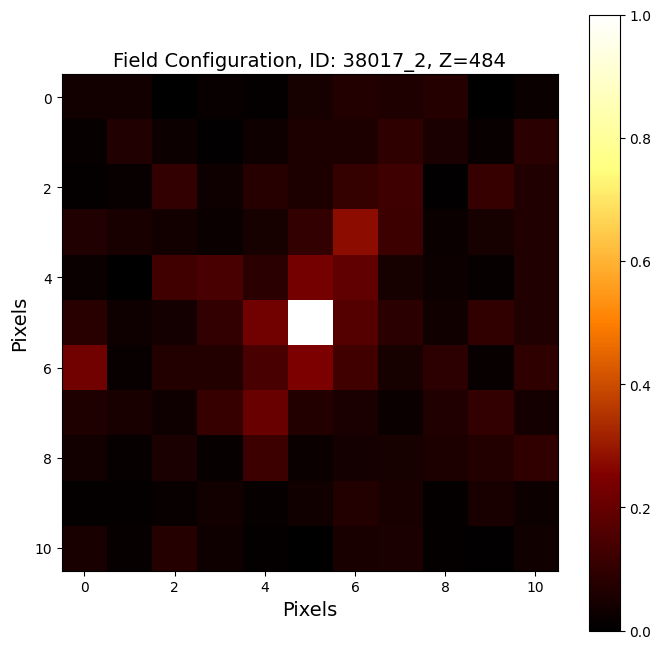

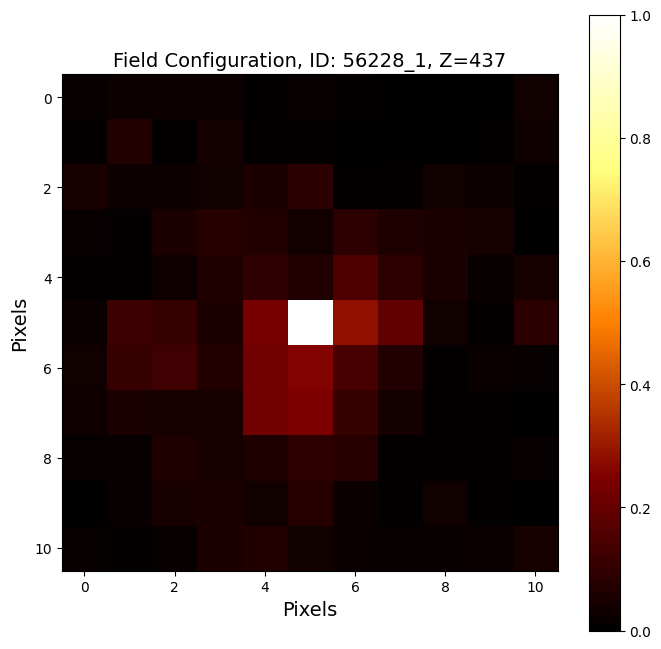

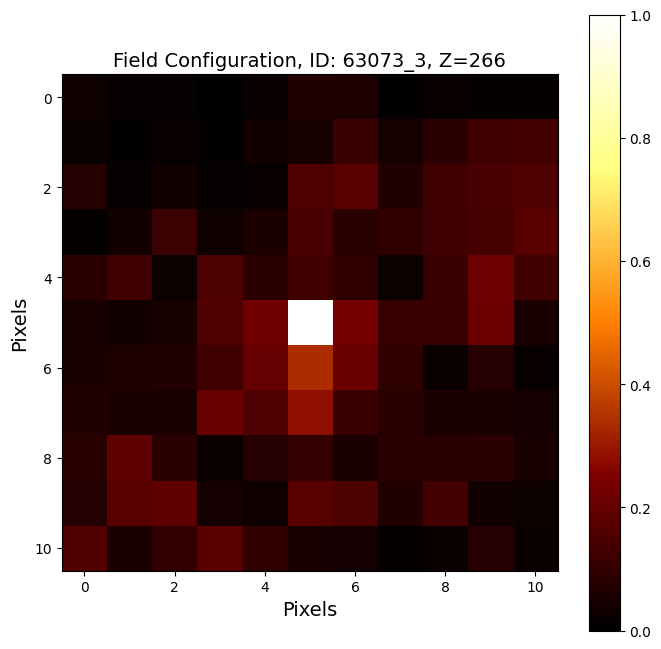

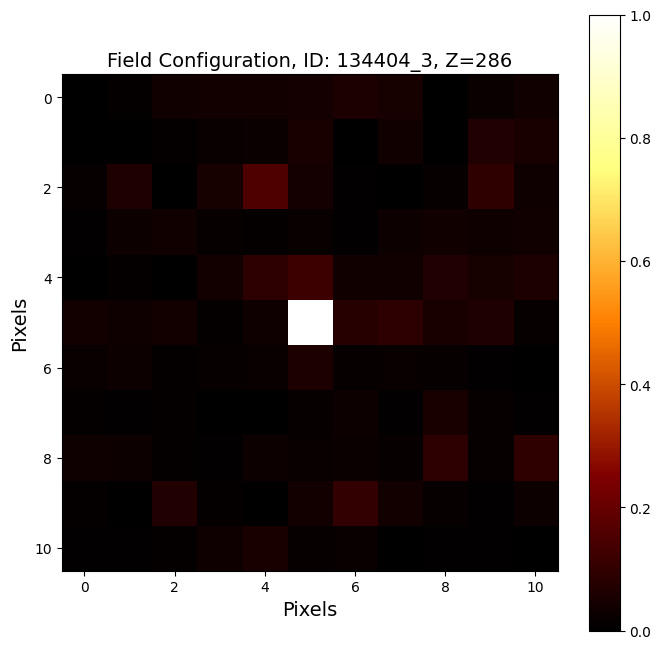

In [ ]:
l= 5
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 0 # 19 = 6 sigmas, 14 = 5 sigmas


#instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
#gpu_id_list = [0,1,0,0,1,3]
#k_power = 3

instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
gpu_id_list = [2,0,2,1,3,3]
k_power = 2

#instance_id_list = [16825, 30829, 54107, 98328, 112172]
#gpu_id_list = [3, 3, 3, 3, 0]
#k_power = 1

#instance_id_list = [4366, 42923, 66511, 94580]
#gpu_id_list = [1,1,3,1]
#k_power = 0

ii=0
for instance_id, gpu_id in zip(instance_id_list, gpu_id_list):
    # Initialize an instance of RFSIM
    folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
    os.chdir(folder_path)
    exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')

    max_pt = np.argmax( exprf )
    max_coord = np.unravel_index(max_pt, exprf.shape)

    x,y,z = max_coord[0], max_coord[1], max_coord[2]

    x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
    y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
    z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

    max_sub_vol_slice = exprf[x_min:x_max, y_min:y_max, max_coord[2] ]
    #max_sub_vol_slice = exprf[:, :, max_coord[2]]
    # Normalize the field values
    max_sub_vol_slice = max_sub_vol_slice/(np.max(exprf))


    plt.figure(figsize=(8, 8))
    plt.imshow(max_sub_vol_slice, cmap='afmhot', clim=[0, 1])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('Pixels', fontsize = 14)
    plt.ylabel('Pixels', fontsize = 14)
    plt.title(f'Field Configuration, ID: {instance_id}_{gpu_id}, Z={z}', fontsize = 14)
    plt.savefig(f'Field_Config_ID_{instance_id}_{gpu_id}_Z_{z}_l_{l}')
    plt.show()

In [ ]:
l= 9
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 0 # 19 = 6 sigmas, 14 = 5 sigmas


instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
gpu_id_list = [0,1,0,0,1,3]
k_power = 3

#instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
#gpu_id_list = [2,0,2,1,3,3]
#k_power = 2

#instance_id_list = [16825, 30829, 54107, 98328, 112172]
#gpu_id_list = [3, 3, 3, 3, 0]
#k_power = 1

#instance_id_list = [4366, 42923, 66511, 94580]
#gpu_id_list = [1,1,3,1]
#k_power = 0

instance_id , gpu_id = 63073, 3

# Initialize an instance of RFSIM
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
os.chdir(folder_path)
exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')

folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_results/k_{k_power}'
folder_path_main = folder_path + f'/exprf_id_{instance_id}_{gpu_id}/neighbourhood/l_{l}'

if not os.path.exists(folder_path_main):
    os.makedirs(folder_path_main)
    print(f'{folder_path_main} created')


max_pt = np.argmax( exprf )
max_coord = np.unravel_index(max_pt, exprf.shape)

x,y,z = max_coord[0], max_coord[1], max_coord[2]

x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

for z_pos in np.linspace(-l,l,2*l+1):
    max_sub_vol_slice = exprf[x_min:x_max, y_min:y_max, max_coord[2]+ int(z_pos) ]
#max_sub_vol_slice = exprf[:, :, max_coord[2]]
# Normalize the field values
    max_sub_vol_slice = max_sub_vol_slice/(np.max(exprf))


    plt.figure(figsize=(8, 8))
    plt.imshow(max_sub_vol_slice, cmap='afmhot', clim=[0, 1])
    #BrBG bwr rainbow
    plt.colorbar()
    plt.xlabel('Pixels', fontsize = 14)
    plt.ylabel('Pixels', fontsize = 14)
    plt.title(f'Field Configuration, ID: {instance_id}_{gpu_id}, Z={z+ int(z_pos)}', fontsize = 14)
    plt.savefig(f'Field Conf, ID: {instance_id}_{gpu_id}, Z={z+ int(z_pos)} ')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'exprf_63073_gpu3.npy'

## Visualize individually at any scales

In [ ]:
l= 5
lx, ly, lz = l,l,l
pixel = 2**9
z_pixel = pixel
threshold = 0 # 19 = 6 sigmas, 14 = 5 sigmas


#instance_id_list = [23898, 32860, 35693, 40640, 43753, 62221]
#gpu_id_list = [0,1,0,0,1,3]
#k_power = 3

instance_id_list = [32049,  34872,  38017, 56228, 63073, 134404]
gpu_id_list = [2,0,2,1,3,3]
k_power = 2

#instance_id_list = [16825, 30829, 54107, 98328, 112172]
#gpu_id_list = [3, 3, 3, 3, 0]
#k_power = 1

#instance_id_list = [4366, 42923, 66511, 94580]
#gpu_id_list = [1,1,3,1]
#k_power = 0

# Initialize an instance of RFSIM
folder_path = f'/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/k_{k_power}'
os.chdir(folder_path)
exprf = np.load(f'exprf_{instance_id}_gpu{gpu_id}.npy')

max_pt = np.argmax( exprf )
max_coord = np.unravel_index(max_pt, exprf.shape)

x,y,z = max_coord[0], max_coord[1], max_coord[2]

x_min, x_max = max(x-lx,0), min(x+lx +1, pixel)
y_min, y_max = max(y-ly,0), min(y+ly +1, pixel)
z_min, z_max = max(z-lz,0), min(z+lz +1, z_pixel)

max_sub_vol_slice = exprf[x_min:x_max, y_min:y_max, max_coord[2] ]
#max_sub_vol_slice = exprf[:, :, max_coord[2]]
# Normalize the field values
max_sub_vol_slice = max_sub_vol_slice/(np.max(exprf))


plt.figure(figsize=(8, 8))
plt.imshow(max_sub_vol_slice, cmap='afmhot', clim=[0, 1])
#BrBG bwr rainbow
plt.colorbar()
plt.xlabel('Pixels', fontsize = 14)
plt.ylabel('Pixels', fontsize = 14)
plt.title(f'Field Configuration, ID: {instance_id}_{gpu_id}, Z={z}', fontsize = 14)
plt.savefig(f'Field_Config_ID_{instance_id}_{gpu_id}_Z_{z}_l_{l}')
plt.show()

array([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,
        4.,  5.,  6.,  7.,  8.,  9.])